In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import os
from torchvision.io import read_image
from PIL import Image
import yaml


# Get configs from config file
stream = open("config.yaml", 'r')
config_dict = yaml.safe_load(stream)
batch_size = config_dict['batch_size']
learning_rate = config_dict['lr']
model_pth = config_dict['model_pth']
train_data = config_dict['train_data']
valid_data = config_dict['valid_data']
test_data = config_dict['test_data']

In [3]:
# gives training example count of cat_num
def no_examples(cat_name = 'covid', print_bool=True, dataset='train'):
    assert dataset in ['train', 'valid'], "dataset = 'train' or 'valid'"
    assert cat_name in ['covid', 'non'], "cat_name = 'covid' or 'non'"

    root_dir = '.'
    cat_path = os.path.join(root_dir, dataset, str(cat_name))
    num_files = len([name for name in os.listdir(cat_path)])
    if print_bool:
        print(f"There are {num_files} images in category of {cat_name} in {dataset}")
    else:
        return num_files

In [4]:
# shows image for cat_name
def show_im(cat_name, im_no=1, dataset='train', print_dim=True):
    assert dataset in ['train', 'valid'], "dataset = 'train' or 'valid'"

    no_examp = no_examples(cat_name, print_bool=False, dataset=dataset)
    assert im_no <= no_examp, "Image number out of range"

    root_dir = '.'
    cat_path = os.path.join(root_dir, dataset, str(cat_name))
    num_files = [name for name in os.listdir(cat_path)]
    im_path = os.path.join(cat_path, num_files[im_no])
    name_img = cat_name + " Image: " + str(im_no)
    image = read_image(im_path)
    image = image.numpy().transpose((1, 2, 0))
    if print_dim:
        print(f"The dimensions of image are {image.shape}")
    plt.imshow(image)
    plt.title(name_img)
    plt.axis('off')
    plt.show()

In [5]:
no_examples(cat_name = 'covid', print_bool=True, dataset='train')
no_examples(cat_name = 'non', print_bool=True, dataset='train')
no_examples(cat_name = 'covid', print_bool=True, dataset='valid')
no_examples(cat_name = 'non', print_bool=True, dataset='valid')

There are 66 images in category of covid in train
There are 1808 images in category of non in train
There are 18 images in category of covid in valid
There are 192 images in category of non in valid


The dimensions of image are (842, 1024, 3)


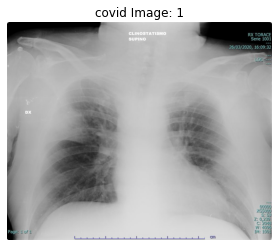

In [6]:
show_im(cat_name='covid', im_no=1, dataset='train', print_dim=True)

The dimensions of image are (320, 390, 1)


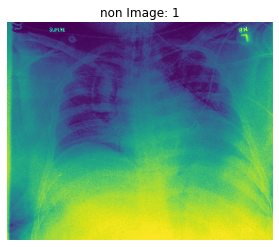

In [7]:
show_im(cat_name='non', im_no=1, dataset='train', print_dim=True)

The dimensions of image are (411, 477, 3)


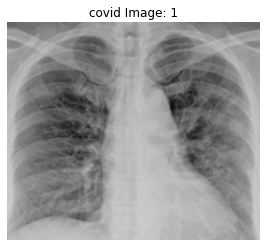

In [8]:
show_im(cat_name='covid', im_no=1, dataset='valid', print_dim=True)

The dimensions of image are (320, 390, 1)


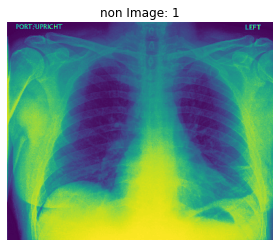

In [9]:
show_im(cat_name='non', im_no=1, dataset='valid', print_dim=True)

In [10]:
# saves model and returns its path.
def save_model(model, name="unknown", path=model_pth):
    """

    :param model: Model object to be saved
    :param name: Name of model
    :param path: Path where model is saved
    :return: Path of saved Model object
    """
    now = datetime.now()
    date, _ = str(now).split()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    _, time = dt_string.split()
    hr, minutes, sec = time.split(":")
    time_right = hr + "." + minutes
    name_model = name + '_' + time_right + '_' + date + '.pth'

    torch.save(model, os.path.join(path, name_model))
    return os.path.join(path, name_model)

In [11]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [12]:
##### End of utils #######

In [13]:
import yaml
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets,models
import math
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time
from PIL import Image
from datetime import datetime

#from utils import *
data_dir = '.'


# Get configs from config file
stream = open("config.yaml", 'r')
config_dict = yaml.safe_load(stream)
batch_size = config_dict['batch_size']
learning_rate = config_dict['lr']
model_pth = config_dict['model_pth']
train_data = config_dict['train_data']
valid_data = config_dict['valid_data']
test_data = config_dict['test_data']


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((230, 230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ]),
}


# Load dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle= True, num_workers=0)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Trains Model
def train_model2(model, criterion, optimizer,
                 num_epochs=3, dataloaders= dataloaders, print_progress=False):

    """

    :param model: Model type object
    :param criterion: Loss function
    :param optimizer: Optimizer
    :param num_epochs: Number of epochs
    :param dataloaders: Dataloaders, must be a dictionary having train and val as keys
    :param print_progress: prints progress if true
    :return: trained model object
    """

    min_val_loss = np.Inf
    best_model_wts = copy.deepcopy(model.state_dict())

    since = time.time()
    best_epoch = -1

    for epoch in range(num_epochs):
        valid_loss = 0.0
        train_loss = 0.0
        model.train()
        running_corrects = 0

        for iter1, (inputs, labels) in enumerate(dataloaders['train']):

            inputs = inputs.to(device)
            inputs = inputs.type(torch.float)
            labels = labels.to(device)
            labels = labels.type(torch.long)

            optimizer.zero_grad()
            out = model(inputs)
            _, preds = torch.max(out, 1)
            # out = torch.mul(out,100)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            if print_progress:
                print(
                    f"Epoch: {epoch}\t{100 * (iter1 + 1) / len(dataloaders['train']):.2f}" + '%',
                    end='\r')


        else:
            print()
            with torch.no_grad():
                model.eval()

            for iter2, (inputs, labels) in enumerate(dataloaders['valid']):
                inputs = inputs.to(device)
                inputs = inputs.type(torch.float)
                labels = labels.to(device)
                labels = labels.type(torch.long)

                output1 = model(inputs)
                _, preds1 = torch.max(output1, 1)
                # output1 = torch.mul(output1,100).to(device)
                loss = criterion(output1, labels)
                valid_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds1 == labels.data)
                print(
                    f'Epoch: {epoch}\t{100 * (iter2 + 1) / len(dataloaders["valid"]):.2f} %',
                    end='\r')
        len_train1 = 1808+66
        len_val1 = len(dataloaders['valid'].dataset)
        train_loss = train_loss / len_train1
        valid_loss = valid_loss / len_val1
        if print_progress:
            print(
                f'\nEpoch: {epoch + 1} \tTraining Loss: {math.sqrt(train_loss):.4f} \tValidation Loss: {math.sqrt(valid_loss):.4f}')
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print(f'Accuracy : {100 * running_corrects / len_val1} %')
        if valid_loss < min_val_loss:
            min_val_loss = valid_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
        print('Best val Loss: {:4f}'.format(math.sqrt(min_val_loss)))
        print(f'Epoch completed: {epoch+1}')
        print(f'Best Epoch: {best_epoch+1}')

    model.load_state_dict(best_model_wts)
    return model


In [15]:
def process_image(img_path):

    """
        :param img_path: Path of image to be processed
        :returns processed numpy array
        Scales, crops, and normalizes a PIL image for a PyTorch model,
            returns a Numpy array
    """
    img = Image.open(img_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))

    # Crop Image

    left_margin = (img.width - 224) / 2
    bottom_margin = (img.height - 224) / 2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,
                    top_margin))

    # Normalize
    img = np.array(img) / 255
    mean = np.array([0.485, 0.456, 0.406])  # provided mean
    std = np.array([0.229, 0.224, 0.225])  # provided std
    img = (img - mean) / std

    return img


In [16]:
def predict(model_path, dataloader, print_progress=False):

    """

    :param model_path: Path of Model used for prediction
    :param dataloader: Test DataLoader
    :param print_progress: Prints progress if True
    :return: Prediction(as a list) on test folder defined by config file
    """

    model = torch.load(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    predictions = {}
    with torch.no_grad():
        for ii, (images, _, img_names) in enumerate(dataloader, start=1):

            if print_progress:
                if ii % 5 == 0:
                    print('Batch {}/{}'.format(ii, len(dataloader)))
            images = images.to(device)
            logps = model(images)
            ps = torch.exp(logps)

            # Top indices
            _, top_indices = ps.topk(1)
            top_indices = top_indices.detach().cpu().numpy().tolist()

            # Convert indices to classes
            top_classes = [idx_to_class[idx[0]] for idx in top_indices]
            # print("Img:" ,img_names)
            for i, img_name in enumerate(img_names):
                predictions[img_name] = top_classes[i]

        print('\nPrediction Generation Completed')

    return predictions


In [17]:
###### End of Model #########

In [18]:
from datetime import datetime
import yaml
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.io import read_image
import math
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time
from PIL import Image

In [19]:
data_dir = '.'



# Get configs from config file
stream = open("config.yaml", 'r')
config_dict = yaml.safe_load(stream)
batch_size = config_dict['batch_size']
learning_rate = config_dict['lr']
model_pth = config_dict['model_pth']
train_data = config_dict['train_data']
valid_data = config_dict['valid_data']
test_data = config_dict['test_data']

In [20]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
                                    for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_to_idx = image_datasets['valid'].class_to_idx
idx_to_class = {val: key for key, val in class_to_idx.items()}

# Load Pretrained model for fine tuning
model_pt = torchvision.models.densenet201(pretrained=True)
for params in model_pt.parameters():
    params.requires_grad = False

# Load Model to device
model_ft1 = model_pt.to(device)
model_sub3 = nn.Sequential(model_ft1,
                           nn.Flatten(),
                           nn.Linear(1000, 2)

                           ).to(device)

# Define Optimizer and Loss
optimizer_ft = optim.SGD(model_sub3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train model
model_trained = train_model2(model_sub3, criterion, optimizer_ft, num_epochs=28, print_progress=True)

# Saves model
train_model_path = save_model(model_trained, "DenseNet")

# # Load test data loader
# test_dataset = TestDataset(data_dir+'test', sample_sub, data_transforms['test'])
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Get Predictions
# predictions = predict(train_model_path, test_loader)

# # Make submission file
# submission = pd.DataFrame(list(predictions.items()), columns=['file_name', 'id'])
# sub_file_name = "DenseNet201.csv"
# sub_folder = "Submissions"
# sub_path = os.path.join(sub_folder, sub_file_name)
# submission.to_csv(sub_path, index=False)


Epoch: 0	100.00%
Epoch: 0	100.00 %
Epoch: 1 	Training Loss: 0.4379 	Validation Loss: 0.5163
Training complete in 1m 2s
Accuracy : 92.85714721679688 %
Best val Loss: 0.516321
Epoch completed: 1
Best Epoch: 1
Epoch: 1	100.00%
Epoch: 1	100.00 %
Epoch: 2 	Training Loss: 0.4013 	Validation Loss: 0.4672
Training complete in 1m 53s
Accuracy : 96.66667175292969 %
Best val Loss: 0.467235
Epoch completed: 2
Best Epoch: 2
Epoch: 2	100.00%
Epoch: 2	100.00 %
Epoch: 3 	Training Loss: 0.3189 	Validation Loss: 0.7925
Training complete in 2m 43s
Accuracy : 89.04762268066406 %
Best val Loss: 0.467235
Epoch completed: 3
Best Epoch: 2
Epoch: 3	100.00%
Epoch: 3	100.00 %
Epoch: 4 	Training Loss: 0.3287 	Validation Loss: 0.4367
Training complete in 3m 16s
Accuracy : 95.23809814453125 %
Best val Loss: 0.436693
Epoch completed: 4
Best Epoch: 4
Epoch: 4	100.00%
Epoch: 4	100.00 %
Epoch: 5 	Training Loss: 0.3379 	Validation Loss: 1.2127
Training complete in 3m 51s
Accuracy : 76.66667175292969 %
Best val Loss: 0.4